# Question 2: How much money do Airbnb home owner in Berlin earn?
The second question around the Airbnb Berlin data set is about the amount of money that Airbnb home owners earn. The steps involved in answering the question are as follows:
* Load Libraries
* Import Data Set
* Pre-Processing
* Analyze Data Set & Evaluate Results

## Load Libraries

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import folium
import math

%matplotlib inline

## Import Data Set

In [187]:
# Import listings data
df_listings = pd.read_csv('/Users/patrick.peltier/Documents/Udacity Data Science Nanodegree/Data/Airbnb/listings_berlin.csv')

# Preview data
print(df_listings.shape)
pd.options.display.max_columns = None
df_listings.head(1)

(22572, 96)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20180912025131,2018-09-12,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",1.0,1.0,https://a0.muscache.com/im/pictures/260fd609-7...,1.0,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,100%,1.0,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",1.0,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,6 weeks ago,t,5,34,64,154,2018-09-12,109,2016-04-11,2018-09-08,92.0,9.0,9.0,10.0,10.0,10.0,9.0,t,NaN,1.0,f,f,strict_14_with_grace_period,f,f,3,3.69


## Pre-Processing

There are __multiple factors__ that have an influence on the income of a single Airbnb listing. On the one hand it's a listing's __price including extra fees__ for additional people (assuming cleaning fees are charged for cleaning purposes only). On the other hand it's the __number of nights__ that an Airbnb home is booked. As the data set at hand doesn't include any information on booking histories we need to come up with an __approximation__ for these variables in order to be able to answer to underlying question of this analysis.

To __simplify the analysis__, the approximation of an Airbnb listing's (minimum) income will be based on a:
* Listing __price__ without additional guests
* Booking duration equal to the __minimum number of nights__
* Booking frequency equal to the __number of reviews per month__

In [188]:
# Convert columns representing monetary data to float and impute missing values with 0
price_cols = ["price","weekly_price","monthly_price","extra_people"]

for col in price_cols:
    df_listings[col] = df_listings[col].astype(str)
    df_listings[col] = df_listings[col].apply(lambda x: x.replace('$','').replace(',',''))
    df_listings[col] = df_listings[col].astype(float)
    #df_listings[col] = df_listings[col].fillna(0)

In [189]:
# Fill missing values with 0
df_listings["number_of_reviews"] = df_listings["number_of_reviews"].fillna(0)

In [190]:
# Income per booking

booking_income = []
for (p,wp,mp,n) in zip(df_listings["price"], df_listings["weekly_price"], df_listings["monthly_price"], df_listings["minimum_nights"]):
    price = 0.0
    if n > 29:
        if not math.isnan(mp):
            months = n / 30.0
            price += mp * math.floor(months)
            if not math.isnan(wp):
                weeks = ((months - math.floor(months)) * 30.0) / 7.0
                days = (weeks - math.floor(weeks)) * 7.0
                price += (wp * math.floor(weeks)) + (n * days)
            else:
                days = (months - math.floor(months)) * 30.0
                price += p * days
        elif not math.isnan(wp):
            weeks = n / 7.0
            days = (weeks - math.floor(weeks)) * 7.0
            price += (wp * math.floor(weeks)) + (p * days)
        else:
            price += p * n
    elif n > 6:
        if not math.isnan(wp):
            weeks = n / 7.0
            days = (weeks - math.floor(weeks)) * 7.0
            price += (wp * math.floor(weeks)) + (p * days)
        else:
            price += p * n
    else:
        price += p * n
    
    booking_income.append(price)

# Add to data frame
df_listings["income_per_booking"] = booking_income
df_listings["income_per_booking"].describe()

count     22572.000000
mean        438.241582
std        6389.365169
min           0.000000
25%          60.000000
50%         120.000000
75%         255.000000
max      900000.000000
Name: income_per_booking, dtype: float64

In [193]:
# As on booking can span over multiple months we need to convert the price per booking
# to a price per months before multiplying mit with the number of reviews per month
df_listings["income_per_month"] = df_listings["income_per_booking"] * df_listings["reviews_per_month"]
df_listings["income_per_month"].describe()

count    18568.000000
mean       274.005093
std       1313.912049
min          0.000000
25%         21.840000
50%         73.500000
75%        216.000000
max      48541.500000
Name: income_per_month, dtype: float64

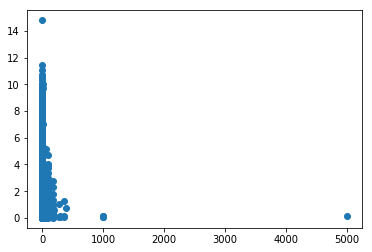

In [10]:
# Scatterplot(s)
plt.scatter(df_listings["minimum_nights"], df_listings["reviews_per_month"])
#plt.ylabel("Bedrooms")
#plt.xlabel("Airbnb Listing Price in $")
#plt.title("Title");

## Analyses